### Config


In [1]:
# config.py (refactored using @dataclass)
import torch
from dataclasses import dataclass, field
from typing import List, Optional

@dataclass
class DataConfig:
    name: str = 'Cifar10'
    num_classes: int = 10
    img_channels: int = 3
    norm_mean: List[float] = field(default_factory=lambda: [0.4914, 0.4822, 0.4465])
    norm_std: List[float] = field(default_factory=lambda: [0.2023, 0.1994, 0.2010])
    ntrain: int = 50000
    dummy: bool = False

    def __post_init__(self):
        if self.dummy:
            self.ntrain = 500
        if self.name.upper() == 'CIFAR100':
            self.name = 'Cifar100'
            self.num_classes = 100
            self.norm_mean = [0.5060725, 0.48667726, 0.4421305]
            self.norm_std = [0.2675421, 0.25593522, 0.27593908]

@dataclass
class VGGConfig:
    channels: List[int] = field(default_factory=lambda: [32, 64, 128, 128, 256, 256, 512, 512])
    is_maxpool: List[bool] = field(default_factory=lambda: [True, True, False, True, False, False, True, False])

@dataclass
class ResNetConfig:
    channels: List[int] = field(default_factory=lambda: [64, 64, 128, 128, 256, 256, 512, 512, 512])
    strides: List[int] = field(default_factory=lambda: [1, 1, 1, 2, 1, 2, 1, 2, 1])

@dataclass
class ExpConfig:
    exp_depths: List[int] = field(default_factory=lambda: [1])
    data_name: str = 'CIFAR10'
    nin: int = 1
    nSplit: int = 16
    vgg_exp_layers: List[int] = field(default_factory=lambda: [1, 3, 5])
    resnet_exp_layers: List[int] = field(default_factory=lambda: [1, 4, 6])

    # for reduce block
    expRed: List[int] = field(default_factory=lambda: [1, 2])
    # is_pool: bool = False

    exps: List[str] = field(default_factory=lambda: ['C', 'R', '1'])
    maxRan: float = 1.0
    miExp: bool = False

    def __post_init__(self):
        self.maxRan = 1 if self.data_name.upper() == 'CIFAR10' else 0.5

@dataclass
class TrainConfig:
    dummy: bool = False
    batch_size: int = 128
    epochs: int = 120
    lr: float = 0.1
    momentum: float = 0.9
    weight_decay: float = 0.0005
    lr_scheduler: str = 'step'
    milestones: List[int] = field(init=False)
    gamma: float = 0.1
    niter: int = 1000

    def __post_init__(self):
        if self.dummy:
            self.epochs = 10
        step = self.epochs // 3 + self.epochs // 10 + 2
        self.milestones = list(range(step, self.epochs, step))

@dataclass
class Config:
    dataset_name: str = 'CIFAR10'
    exp_depths: List[int] = field(default_factory=lambda: [1])
    dummy: bool = False
    dataset: DataConfig = field(init=False)
    vgg: VGGConfig = field(default_factory=VGGConfig)
    resnet: ResNetConfig = field(default_factory=ResNetConfig)
    train: TrainConfig = field(init=False)
    exp: ExpConfig = field(init=False)
    device: torch.device = field(init=False)

    def __post_init__(self):
        self.dataset = DataConfig(name=self.dataset_name, dummy=self.dummy)
        self.train = TrainConfig(dummy=self.dummy)
        self.exp = ExpConfig(exp_depths=self.exp_depths, data_name=self.dataset_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# load_save_config.py

import os
from omegaconf import OmegaConf
# from config import Config

def load_config(yaml_path: str) -> Config:
    """
    Load YAML config file và gán lại giá trị cho đối tượng Config đã khởi tạo sẵn.
    Hỗ trợ các giá trị post_init không bị lỗi.
    """
    if not os.path.isfile(yaml_path):
        raise FileNotFoundError(f"YAML config file not found: {yaml_path}")

    # Load YAML thành dict
    cfg_yaml = OmegaConf.to_object(OmegaConf.load(yaml_path))

    # Khởi tạo config ban đầu (để đảm bảo __post_init__ chạy)
    cfg = Config(dataset_name=cfg_yaml.get('dataset_name', 'CIFAR10'),
                 exp_depths=cfg_yaml.get('exp_depths', [1]),
                 dummy=cfg_yaml.get('dummy', False))

    # Ghi đè các giá trị từ YAML lên config đã khởi tạo
    for section_name, section_val in cfg_yaml.items():
        # Nếu key từ YAML tồn tại trong Config
        if hasattr(cfg, section_name):
            section = getattr(cfg, section_name)

            # Nếu đó là một sub-config (dict) như train, dataset, vgg,...
            if isinstance(section_val, dict):
                for k, v in section_val.items():
                    # Ghi đè từng key nhỏ nếu key tồn tại trong dataclass con
                    if hasattr(section, k):
                        setattr(section, k, v)

            # Nếu là giá trị đơn (dataset_name, dummy, ...)
            else:
                setattr(cfg, section_name, section_val)

    print(f"✅ Config loaded from {yaml_path}")
    return cfg


def save_config(cfg: Config, save_path: str) -> None:
    """
    Lưu toàn bộ config hiện tại sang file .yaml.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cfg_struct = OmegaConf.structured(cfg)
    OmegaConf.save(config=cfg_struct, f=save_path)
    print(f"✅ Config saved to {save_path}")


### Components

#### Blocks

In [3]:
import torch.nn as nn
from abc import ABC, abstractmethod

# Flatten layer
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, in_tensor):
        return in_tensor.view(in_tensor.size()[0], -1)

# ------------------------ ClassifierBlock Class ---------------------
class ClassifierBlock(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5, activation=None):
        super().__init__()
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = Flatten()
        self.dropout = nn.Dropout(dropout) if (dropout and dropout > 0) else nn.Identity()
        self.linear = nn.Linear(in_features, num_classes)
        self.activation = self.get_activation(activation)

    def forward(self, x):
        out = self.avg_pooling(x)
        out = self.flatten(out)
        out = self.dropout(out)
        out = self.linear(out)
        out = self.activation(out)
        return out

    def get_activation(self, name):
        if name is None:
            return nn.Identity()
        name = name.lower()
        if name == 'softmax':
            return nn.Softmax(dim=1)
        elif name == 'sigmoid':
            return nn.Sigmoid()
        elif name == 'relu':
            return nn.ReLU()
        elif name == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {name}")

# ------------------------ ConvBlock Class ---------------------
class VGG_ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, maxpool=False):
        super().__init__()
        padding = int(kernel_size > 1)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if maxpool else nn.Identity()

    def forward(self, x):
        x = self.block(x)
        x = self.pool(x)
        return x


class ResNet_ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        return self.relu(out)

# ------------------------ ReduceBlock Class ---------------------
class ReduceBlock(nn.Module):
    def __init__(self, in_channels, red1, red2, architecture='vgg'):
        super(ReduceBlock, self).__init__()
        self.architecture = architecture.lower()

        mid_channels = in_channels // red1
        out_channels = max(1, mid_channels // red2)

        if architecture == 'vgg':
            ks1 = 3 if in_channels > 64 else 1
            ks2 = 3 if mid_channels > 32 else 1
        elif architecture == 'resnet':
            ks1 = 3 if in_channels > 128 else 1
            ks2 = 3 if mid_channels > 64 else 1
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
        else:
            raise ValueError("Unsupported architecture for ReduceBlock")

        self.reduce = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=ks1, stride=1, padding=ks1 // 2),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(mid_channels, out_channels, kernel_size=ks2, stride=1, padding=ks2 // 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.reduce(x)
        if self.architecture == 'resnet': x = self.pool(x)
        return x

#### ExpNet

In [4]:
import numpy as np
import torch
import torch.nn as nn
# from configs.config import Config
# from models.blocks import *
from typing import Optional

class ExpNet(nn.Module):
    def __init__(self, cfg: Config, architecture: str = 'vgg', isExp: bool = False, num_classes: Optional[int] = None):
        """ Initializes the ExpNet model.
        Args:
            cfg (Config): Configuration object containing model parameters.
            architecture (str): Architecture type, either 'vgg' or 'resnet'.
            isExp (bool): Flag indicating if the model is an explanation model.
            num_classes (Optional[int]): Number of output classes. If None, uses cfg.dataset.num_classes.
        """
        super().__init__()

        self.cfg = cfg
        self.architecture = architecture.lower()
        self.isExp = isExp
        self.num_classes = num_classes or cfg.dataset.num_classes
        self.in_channels = 3

        if self.architecture == 'vgg':
            self.channels = cfg.vgg.channels
            self.is_maxpool = cfg.vgg.is_maxpool
            self.targets = cfg.exp.vgg_exp_layers + [9999]
        elif self.architecture == 'resnet':
            self.channels = cfg.resnet.channels
            self.strides = cfg.resnet.strides
            self.targets = cfg.exp.resnet_exp_layers + [9999]
        else:
            raise ValueError(f"Unsupported architecture: {self.architecture}")

        self.base_channels = [self.in_channels] + self.channels
        self.offsets = np.zeros(len(self.base_channels), dtype=int)  # Cộng thêm channel nếu có reduce

        # thiết lập các target GradCAM layer và số feature cần thêm
        self.nExtra = 0

        if self.isExp: self._init_gradcam_config()

        self._build_backbone()

        if self.isExp: self._build_reduce_blocks()

        # Xác định số kênh cuối cùng trước classifier
        final_channels = self.base_channels[-1] + self.offsets[-1]
        self.classifier = ClassifierBlock(final_channels, self.num_classes)

    def _init_gradcam_config(self):
        """Khởi tạo thông tin về nhánh giải thích, số features thêm, và target layers"""
        assert self.num_classes is not None
        self.oney = torch.eye(self.num_classes).cuda()

        self.nin = self.cfg.exp.nin
        self.nSplit = self.cfg.exp.nSplit
        self.nExtra = self.nin * self.nSplit

        # Lấy danh sách target layers từ config
        if self.architecture == 'vgg':
            layers = np.array(self.cfg.exp.vgg_exp_layers)
        elif self.architecture == 'resnet':
            layers = np.array(self.cfg.exp.resnet_exp_layers)
        else:
            raise ValueError(f"Unsupported architecture: {self.architecture}")

        # Chọn depth (subset các layer)
        target_layers = layers[self.cfg.exp.exp_depths]
        self.targets = target_layers.tolist() + [9999]  # sentinel

        # Gán offsets cho từng layer được chọn để biết cần thêm bao nhiêu channel
        red_factor = np.prod(self.cfg.exp.expRed) if self.cfg.exp.expRed else 1
        added = max(1, self.nExtra // red_factor)
        for idx in target_layers:
            self.offsets[idx + 1] = added  # +1 vì layer đầu tiên thường là input

    def _build_backbone(self):
        if self.architecture == 'vgg':
            self.features = self._build_vgg()
        elif self.architecture == 'resnet':
            self.features = self._build_resnet()

    def _build_vgg(self):
        self.layers = nn.ModuleList()
        for i in range(len(self.base_channels) - 1):
            in_c = self.base_channels[i] + self.offsets[i] if i > 0 else self.base_channels[i]
            out_c = self.base_channels[i + 1]

            block = VGG_ConvBlock(in_c, out_c, kernel_size=3, stride=1,
                                  maxpool=self.is_maxpool[i])
            self.layers.append(block)

    def _build_resnet(self):
        self.layers = nn.ModuleList()
        # First conv layer
        stem_block = VGG_ConvBlock(self.base_channels[0], self.base_channels[1], kernel_size=3, stride=1, maxpool=False)
        self.layers.append(stem_block)

        for i in range(1, len(self.base_channels) - 2, 2):
            in_c = self.base_channels[i] + self.offsets[i] if i > 0 else self.base_channels[i]
            mid_c = self.base_channels[i + 1]
            out_c = self.base_channels[i + 2]
            block = ResNet_ConvBlock(in_c, mid_c, out_c, stride=self.strides[i])
            self.layers.append(block.conv1)
            self.layers.append(block.conv2)

    def _build_reduce_blocks(self):
        self.reduce_block = ReduceBlock(in_channels=self.nExtra,
                                        red1=self.cfg.exp.expRed[0],
                                        red2=self.cfg.exp.expRed[1],
                                        architecture=self.architecture
                                       )

    def rsh(self, cx):
        s = cx.shape
        return torch.reshape(cx, (s[0], s[1] * s[2], s[3], s[4]))

    def preprocess(self, xbatch):
        # Normalize the input tensor
        xExp, aExp = None, {}
        if self.isExp:
            x = xbatch[0]
            nexp = np.sum(np.array(self.targets[:-1]) > 0)       # num exp layer
            xExp = [ self.rsh(cx) for cx in xbatch[1][:nexp] ]   # use for gradcam
        else:
            x = xbatch
            aExp = None
        return x, xExp, aExp

    def handle_exp_layer(self, weights, x, xbatch, aExp):
        aweis = []
        for j in range(self.nin):
            cur_aweis = [ weights[:, j * self.nSplit : (j+1) * self.nSplit] ]
            cur_aweis = torch.cat(cur_aweis, dim=1)
            aweis.append(cur_aweis)

        print('weights.shape before concat', weights.shape)
        weights = torch.cat(aweis, dim=1)
        print('weights.shape after concat', weights.shape)
        weights = self.reduce_block(weights)
        print('weights.shape after reduce', weights.shape)

        print('x.shape before concat', x.shape)
        x = torch.cat([x, weights], axis=1)
        return x

    def forward(self, xbatch):
        x, xExp, aExp = self.preprocess(xbatch)
        tpos = 0

        for i, layer in enumerate(self.layers):
            if self.isExp and i == self.targets[tpos]:
                weights = xExp[tpos]
                x = self.handle_exp_layer(weights, x, xbatch, aExp)
                tpos += 1
            x = layer(x)
        x = self.classifier(x)
        return x

    def get_target_layers(self):
        target_layers = [self.layers[i] for i in self.targets[:-1]]
        return target_layers


### Explaination Methods

#### GradCAM

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM(nn.Module):
    def __init__(self, model, target_layers, gonly=0, nsplit=1, salnorm=True, relu=True, use_dummy=True):
        super(GradCAM, self).__init__()
        self.model = model
        self.gradients = [None for _ in range(len(target_layers))]
        self.activations = [None for _ in range(len(target_layers))]
        self.gonly, self.nsplit, self.salnorm, self.relu, self.use_dummy = gonly, nsplit, salnorm, relu, use_dummy
        # self.use_dummy =False #for debug visualize

        def addHook(target_layer, i):
            def backward_hook(module, grad_input, grad_output):
                self.gradients[i] = grad_output[0]
                return None
            def forward_hook(module, input, output):
                self.activations[i] = output
                return None
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_backward_hook(backward_hook)

        for i, target_layer in enumerate(target_layers):
            addHook(target_layer, i)

    def get_weights(self, idx, score):
        gradients = self.gradients[idx]
        b, c, h, w = gradients.size()
        alpha = gradients.view(b, c, -1).mean(2)  # GAP
        weights = alpha.view(b, c, 1, 1)
        return weights

    def get_maps(self, idx, h, w, score):
        gradients, activations = self.gradients[idx], self.activations[idx]
        weights = self.get_weights(idx, score)
        relu_func = F.relu if self.relu else lambda x: x

        saliency_map = (weights * activations)
        osaliency_map = saliency_map.detach()

        # Reduce channel dimension
        vecs = torch.split(osaliency_map, osaliency_map.shape[1] // self.nsplit, dim=1)
        vecs = [v.sum(1, keepdim=True) for v in vecs]
        csaliency_map = torch.cat(vecs, dim=1)

        # Normalize
        def norm(cmap):
            min_val, max_val = cmap.min(), cmap.max()
            return (cmap - min_val).div(max_val - min_val + 1e-8).data

        nonUpSalmap = relu_func(csaliency_map)
        nonUpSalmap = norm(nonUpSalmap)
        nonUpSalmap = nonUpSalmap.cpu().numpy().astype(np.float16)

        if self.use_dummy:
            dummy_map = np.zeros([1, 1, 32, 32], dtype=np.float16)
            return dummy_map, nonUpSalmap
        else:
            csaliency_map = csaliency_map.cpu().numpy().astype(np.float16)
            return csaliency_map, nonUpSalmap

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
            If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size() if not isinstance(input, tuple) else input[0].size()
        logit = self.model(input)

        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
            clid = logit.max(1)[-1].detach().cpu().numpy()[0]
        else:
            if class_idx >= 0:
                score = logit[:, class_idx].squeeze()
                clid = class_idx
            else:
                sorted_score = logit.sort(1).indices
                score = logit[:, sorted_score[-1][class_idx]].squeeze()
                clid = sorted_score[-1][class_idx].detach().cpu().numpy()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)

        maps, rmaps = [], []
        for i in range(len(self.gradients)):
            m, rm = self.get_maps(i, h, w, score)
            maps.append(m)
            rmaps.append(rm)

        self.model.zero_grad()
        log = logit[:, clid].detach()
        nlog = log / (1e-7 + torch.sum(torch.abs(logit)))

        return (
            np.stack(maps, axis=2),
            rmaps,
            clid,
            log.cpu().numpy()[0],
            nlog.detach().cpu().numpy()[0]
        )

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


#### GradCAM Utils

In [6]:
import numpy as np
import torch
import torch.cuda.amp as tca

def get_pred(model, rawx, device):
    rawx = torch.from_numpy(rawx).to(device)
    outputs = model(rawx)
    _, predicted = torch.max(outputs.data, 1)
    return outputs, predicted

def get_gradcam(cfg, model, target_layers=None, use_dummy=True):
    if target_layers is None:
        target_layers = model.get_target_layers()

    if isinstance(target_layers, list):
        target_layers = [model.layers[i] for i in target_layers]

    gradcam = GradCAM(model=model, target_layers=target_layers, nsplit=cfg.exp.nSplit, use_dummy=use_dummy)
    return gradcam

def get_target_index(cfg, target_idx, correct_class, old_targets):
    if target_idx[0] == 'C':
        target_index = correct_class
    elif target_idx[0] == 'R':
        if cfg.exp.maxRan == 1:
            target_index = np.random.choice(np.arange(cfg.dataset.num_classes))
            while target_index in old_targets:
                target_index = np.random.choice(np.arange(cfg.dataset.num_classes))
        else:
            target_index = -np.random.choice(np.arange(int(cfg.dataset.num_classes * cfg.exp.maxRan - 1))) - 1

    elif int(target_idx[0]) > 0:
        target_index = -int(target_idx[0])
    return target_index

def batch_exp(cfg, data, norm_x, exps, grad_cam, get_exp=True, target_layers=[3]):
    mask = np.zeros((1, 1, 32, 32))
    if not get_exp:
        if cfg.exp.miExp: mask = -1
        masks = [mask] * len(exps)

    with torch.amp.autocast('cuda'):
        exp_x, raw_exp_x, aids, alogs, anlogs = [], [], [], [], []
        class_ids = np.zeros(len(exps), np.int16)
        nlogs = np.zeros(len(exps), np.float16)
        logs = np.zeros(len(exps), np.float16)
        norm_x = norm_x.unsqueeze(1)
        correct_class = data[1].cpu().numpy()

        for j in range(data[0].shape[0]):
            if get_exp:         # Method gradcam.py
                masks, raw_masks, old_targets, cmax = [], [], [], -1
                for ie, target_idx in enumerate(exps):
                    target_index = get_target_index(cfg, target_idx, correct_class[j], old_targets)
                    # Further processing with target_index and other variables
                    mask, raw_mask, class_id, log, nlog = grad_cam(norm_x[j], target_index)

                    if np.isnan(np.sum(mask)):
                        print("NaN in mask, set mask to 0")
                        mask = np.zeros_like(mask, dtype=np.float16)

                    old_targets.append(class_id)
                    masks.append(mask)
                    raw_masks.append(raw_mask)

                    class_ids[ie] = class_id
                    logs[ie] = log
                    nlogs[ie] = nlog

            sta = lambda i: np.stack([r[i] for r in raw_masks], axis=1).astype(np.float16)
            fin = np.concatenate(masks, axis=1)
            fin_raw = [sta(i) for i in range(len(target_layers))]

            exp_x.append(fin)
            raw_exp_x.append(fin_raw)

            aids.append(np.copy(class_ids))
            alogs.append(np.copy(logs))
            anlogs.append(np.copy(nlogs))

    exp_input = np.concatenate(exp_x, axis=0).astype(np.float16)

    aids = np.stack(aids, axis=0).astype(np.int16)
    alogs = np.stack(alogs, axis=0).astype(np.float16)
    anlogs = np.stack(anlogs, axis=0).astype(np.float16)

    # mid exps for one layer: batch size, class for which exp, splits, h, w
    # mid exps = list with one entry per layer
    # input exps = batch size, class for which exp, layers, h, w
    # exps = np.moveaxis(exps, 1, -1)

    def get_layer(i):
        ri = np.concatenate([r[i] for r in raw_exp_x], axis=0)
        return ri   # np.moveaxis(ri, 1, -1)

    exp_mid = [get_layer(i) for i in range(len(target_layers))]

    return exp_input, exp_mid, aids, anlogs, alogs


### Classifier

In [7]:
def print_info(net_name:str, net:ExpNet):
    print(f"\n--- Tham số (Parameters) trong {net_name} ---")
    for name, param in net.named_parameters():
        print(f"{name} - {param.shape} - {param.requires_grad}")

In [23]:
import numpy as np,copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as tca

# experiment run
def exp_run(cfg, dataset, get_exp, nexp, exps, grad_cam, target_layers, norm):
    # Data consists of: X, y, all exps, estimated y of exps, logit y, normed logits
    # All Exps: List of Input Ex, Mid Ex (where Input Ex is always one entry, and Mid Ex has one list entry per layer)
    # Mid Ex for one layer: batchSize, ClassForWhichExp, splits, h, w
    # Input Ex: batchSize, ClassForWhichExp, layers, h, w

    ox, oy, exp_x, raw_exp_x, masks = [], [], [], [], []
    aids, alogs, anlogs = [], [], []

    for i, data in enumerate(dataset):
        norm_x = (data[0].cuda() - norm[0]) / norm[1]
        ox.append(norm_x.cpu().numpy().astype(np.float16))
        oy.append(data[1].numpy().astype(np.int16))

        bx, bx2, clids, logs, nlogs = batch_exp(cfg, data, norm_x, exps, grad_cam, get_exp=get_exp, target_layers=target_layers)
        # print(f'batch{i}.shape', bx.shape)
        exp_x.append(bx)
        raw_exp_x.append(bx2)

        aids.append(clids)
        alogs.append(logs)
        anlogs.append(nlogs)

        if len(oy) * data[0].shape[0] > nexp: break
        if len(oy) % 40 == 0: print("Computed Explanations: ", len(oy) * data[0].shape[0])

    oy = np.concatenate(oy).astype(np.int16)
    ox = np.concatenate(ox, axis=0).astype(np.float16)
    exp_x = np.concatenate(exp_x, axis=0).astype(np.float16)

    aids = np.concatenate(aids, axis=0).astype(np.int16)
    alogs = np.concatenate(alogs, axis=0).astype(np.float16)
    anlogs = np.concatenate(anlogs, axis=0).astype(np.float16)

    sta = lambda i: np.concatenate([r[i] for r in raw_exp_x], axis=0)
    exp_r = [sta(i) for i in range(len(target_layers))]
    return ox, oy, [exp_x] + exp_r, aids, alogs, anlogs

def select_layers(ds):        # Returns X, Y, Exp(SalMaps), classes, logits (if used later)
    tl = [0]
    ds = list(ds[:2]) + ds[2] + list(ds[3:])
    return ds[:2] + [ds[3 + t] for t in tl] + [ds[-3]]

# -------------------------------------- Get Explanations ------------------------------------
def get_exps(cfg, model, train_dataset, val_dataset, norm):
    gradcam = None

    target_layers = np.array(model.targets)[cfg.exp.exp_depths]
    target_layers = target_layers.tolist()
    print('target_layer for gradcam:', target_layers)

    gradcam = get_gradcam(cfg, model, target_layers)

    print("Compute Explanations for training data")
    train_data = exp_run(cfg, train_dataset, True, cfg.dataset.ntrain, cfg.exp.exps, gradcam, target_layers, norm)

    print("Compute Explanations for validation data")
    val_data = exp_run(cfg, val_dataset, True, cfg.dataset.ntrain // 2, cfg.exp.exps, gradcam, target_layers, norm)

    return train_data, val_data

def get_exp(data, ran_opt, zero_exp, is_train=True):
    idxs =  None
    if is_train:
        idxs = np.random.choice(ran_opt, data[0].shape[0])
        lex = [np.expand_dims(d[np.arange(d.shape[0]), idxs], axis=1) for d in data]
    else:
        lex = [np.expand_dims(d[:, ran_opt[0]], axis=1) for d in data]

    return lex, idxs

def get_x_data(x_data, zero_exp, aug, ran_opt):
    rdata = [x.clone().numpy() for x in x_data[1:]] # Selected explanations - don't change original input at 0
    ex, idxs = get_exp(rdata, ran_opt, zero_exp=zero_exp)
    return [x_data[0].cuda()]+[torch.from_numpy(d).cuda() for d in ex], idxs

# -------------------------- Get Accuracy - Loss ----------------------------------

def get_sigle_acc(net, data_x, labels, pool=None):
    with torch.amp.autocast('cuda'):
        outputs = net(data_x)
        if type(outputs) is tuple: outputs=outputs[1] #for attention net use second output
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.eq(predicted, labels).sum().item()
        return correct

def get_exp_acc(net, dataset, iexp, niter=100, pool=None, zero_exp=1):
    correct, total = 0, 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(dataset):
            labels = data[1].cuda()
            exp_data = [d.clone().numpy() for d in data[2:]] # Selected explanations - don't change original input at 0
            nd, _ = get_exp(exp_data, iexp, zero_exp=zero_exp, is_train=False)

            xgpu = data[0].cuda()
            ndgpu = [torch.from_numpy(x).cuda() for x in nd]

            correct += get_sigle_acc(net, (xgpu, ndgpu), labels, pool=pool)
            total += labels.size(0)
            if i >= niter: break
    return correct / total

def get_acc(net, dataset, niter=100, norm=None):
    correct, total = 0, 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(dataset):
            dsx, dsy = data[0].cuda(), data[1].cuda()
            dsx = (dsx - norm[0]) / norm[1]
            total += dsy.size(0)
            outputs = net(dsx.float())
            _, predicted = torch.max(outputs.data, 1)
            correct += torch.eq(predicted, dsy).sum().item()
            if i >= niter: break
    return correct / total

def get_loss(model):
    reg_loss = 0
    for name,param in model.named_parameters():
        if 'bn' not in name:
             reg_loss += torch.norm(param)
    # loss = cls_loss + args.weight_decay*reg_loss
    return reg_loss

# -------------------------------------- Get Classifier ------------------------------------

def get_out(ndgpu, exp_net):
    dropCl = False
    dropA =  False
    output = exp_net((ndgpu[0], ndgpu[1:], dropCl, dropA))
    return output

def get_net(cfg, architecture, isExp=False):
    NETWORK = ExpNet
    exp_net = NETWORK(cfg, architecture, isExp, cfg.dataset.num_classes).cuda()
    return exp_net

def get_exp_classifier(cfg, architecture, train_dataset, val_dataset, res_folder, trained_net_self=None):
    exp_net = get_net(cfg, architecture, isExp=True)

    if trained_net_self is not None: # copying params
        exp_params = dict(exp_net.named_parameters())
        trained_params = dict(trained_net_self.named_parameters())

        # print_info('trained net (Self)', trained_net_self)
        # print_info('exp net (Reflective)', exp_net)

        for name, trained_param in trained_params.items():
            if name.startswith('layers') or name.startswith('classifier.'):
                if name in exp_params:
                    exp_param = exp_params[name]

                    if len(trained_param.shape) != len(exp_param.shape):
                        print(f"Warning: Shape mismatch for parameter {name}: trained {trained_param.shape} vs exp {exp_param.shape}")
                        continue

                    if trained_param.data.shape == exp_param.data.shape:
                        # Shapes match, copy all data
                        exp_param.data.copy_(trained_param.data)

                    elif len(trained_param.shape) == 4: # Conv2d weights (out_channels, in_channels, kernel_h, kernel_w)
                        # Copy weights for original input channels (dimension 1)
                        in_c_orig = trained_param.data.shape[1]
                        exp_param.data[:, :in_c_orig, :, :] = trained_param.data.clone()

                    elif len(trained_param.shape) == 2: # Linear weights (out_features, in_features)
                        # Copy weights for original input features (dimension 1)
                        in_f_orig = trained_param.data.shape[1]
                        exp_param.data[:, :in_f_orig] = trained_param.data.clone()
                    else:
                        # Handle other dimensions if necessary (e.g., 1D bias)
                        # If shapes are different but dimensions match, assume it's a simple bias mismatch
                        # Copy based on minimum shape if dimensions allow
                        min_shape = [min(s1, s2) for s1, s2 in zip(trained_param.data.shape, exp_param.data.shape)]
                        # Construct slice dynamically
                        slices = [slice(0, ms) for ms in min_shape]
                        exp_param.data[slices] = trained_param.data[slices].clone()

    exp_optimizer = optim.SGD(exp_net.parameters(), lr=cfg.train.lr, momentum=cfg.train.momentum, weight_decay=cfg.train.weight_decay)

    exp_scheduler = optim.lr_scheduler.MultiStepLR(
        exp_optimizer,
        milestones=cfg.train.milestones,
        gamma=cfg.train.gamma
    )

    closs, epochs, loss = 0, cfg.train.epochs, nn.CrossEntropyLoss()

    print("Train Reflective Classifier")
    scaler = torch.amp.GradScaler('cuda')
    ran_opt = np.sort(np.array([0, 1])) #sorting is very important
    emate_accs, etr_acc = [], []

    iexp = list(np.arange(len(cfg.exp.exps)))
    icorr = iexp[:1] + iexp[2:]
    imax = iexp[2:]

    for epoch in range(epochs):
        exp_net.train()
        for i, data in enumerate(train_dataset):
            with torch.amp.autocast('cuda'):
                exp_optimizer.zero_grad()
                dsy = data[1].cuda()
                ndgpu, idxs = get_x_data([data[0]] + list(data[2:]), False, False, ran_opt)
                output = get_out(ndgpu, exp_net)
                errD_real = loss(output, dsy.long())

                scaler.scale(errD_real).backward()
                scaler.step(exp_optimizer)
                scaler.update()

                closs = 0.97 * closs + 0.03 * errD_real.item() if epoch > 20 else 0.8 * closs + 0.2 * errD_real.item()

        # update lr if needed
        exp_scheduler.step()

        exp_net.eval()

        emate_accs.append(get_exp_acc(exp_net, val_dataset, imax, niter=cfg.train.niter) if len(imax) else -1)

        if (epoch % 4 == 0 and epoch <= 13) or (epoch % 20 == 0 and epoch > 13) :
            cur_acc = get_exp_acc(exp_net, val_dataset, iexp[1:], niter=cfg.train.niter)
            print(epoch, np.round(np.array([closs, cur_acc, get_exp_acc(exp_net, train_dataset, icorr, niter=cfg.train.niter)]), 5))

            if np.isnan(closs):
                print("Failed!!!")
                return None, None

    exp_net.eval()
    lcfg = {
        'test_acc_correct': get_exp_acc(exp_net, val_dataset, [0], niter=cfg.train.niter),
        'test_acc_predict': get_exp_acc(exp_net, val_dataset, [2], niter=cfg.train.niter),
        'test_acc_random' : get_exp_acc(exp_net, val_dataset, [1], niter=cfg.train.niter),
    }

    set_eval(exp_net)

    return exp_net, lcfg

def set_eval(exp_net):
    exp_net.eval()
    for name, module in exp_net.named_modules():
        if isinstance(module, nn.Dropout): module.p = 0
        elif isinstance(module, nn.LSTM): module.dropout = 0 #print("zero lstm drop") #print("zero drop")
        elif isinstance(module, nn.GRU): module.dropout = 0

def get_classifier(cfg, architecture, train_dataset, val_dataset, res_folder, forceLoad=False, norm=None):
    non_exp_net = get_net(cfg, architecture, isExp=False)

    non_exp_optimizer = optim.SGD(non_exp_net.parameters(), lr=cfg.train.lr, momentum=cfg.train.momentum, weight_decay=cfg.train.weight_decay)
    non_exp_scheduler = optim.lr_scheduler.MultiStepLR(
        non_exp_optimizer,
        milestones=cfg.train.milestones,
        gamma=cfg.train.gamma
    )

    closs, epochs, loss, = 0, cfg.train.epochs, nn.CrossEntropyLoss()

    print("Train non-reflective classifier")
    scaler = torch.amp.GradScaler('cuda')
    test_accs, train_accs = [], []
    class_acc = lambda dataset:get_acc(non_exp_net, dataset, niter=cfg.train.niter, norm=norm)

    for epoch in range(epochs):
        non_exp_net.train()
        for i, data in enumerate(train_dataset):
            with torch.amp.autocast('cuda'):
                non_exp_optimizer.zero_grad()

                dsx = data[0].cuda()
                dsx = (dsx - norm[0]) / norm[1]
                dsy = data[1].cuda()

                output = non_exp_net(dsx.float())
                errD_real = loss(output, dsy.long())

                scaler.scale(errD_real).backward()
                scaler.step(non_exp_optimizer)
                scaler.update()

                closs = 0.97 * closs + 0.03 * errD_real.item() if epoch > 20 else 0.8 * closs + 0.2 * errD_real.item()

        # update lr if needed
        non_exp_scheduler.step()
        non_exp_net.eval()

        test_accs.append(class_acc(val_dataset))
        train_accs.append(class_acc(train_dataset))

        if (epoch % 4 == 0 and epoch <= 13) or (epoch % 20 == 0 and epoch > 13):
            print(epoch, np.round(np.array([closs, test_accs[-1], train_accs[-1]]), 5))

            if np.isnan(closs):
                print("Failed!!!")
                return None, None
        lcfg = {
            'test_acc': class_acc(val_dataset),
            'train_acc': class_acc(train_dataset),
        }

        set_eval(non_exp_net)

    return non_exp_net, lcfg, False


### Dataset Handling

In [9]:
import torchvision,torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
import numpy as np
import sklearn
# from .config import Config

# get dataset
gds = lambda dataset, cfg: torch.utils.data.DataLoader(TensorDataset(*[torch.from_numpy(x) for x in dataset]), batch_size=cfg.batch_size)

def get_norm(mean, std):
    return (torch.from_numpy(np.array(mean, np.float32).reshape(1,3,1,1)).cuda(),
            torch.from_numpy(np.array(std, np.float32).reshape(1,3,1,1)).cuda())

def get_full_ds(cfg):
    if cfg.dataset.name.upper() == 'CIFAR10':
        data = torchvision.datasets.CIFAR10
    elif cfg.dataset.name.upper() == 'CIFAR100':
        data = torchvision.datasets.CIFAR100

    trans=transforms.Compose([transforms.ToTensor()])
    ntrain, down = cfg.dataset.ntrain, True

    def load_store(is_train, n_data):
        nonlocal data
        trainset = data(root="data/", train=is_train, download=down, transform=transforms.ToTensor())
        train_dataset = torch.utils.data.DataLoader(trainset, batch_size=n_data, num_workers=4)

        ds = next(iter(train_dataset))
        X, Y = ds[0].clone().numpy(), ds[1].clone().numpy()
        ds = [X, Y]
        ds = sklearn.utils.shuffle(*ds)
        return ds[0].astype(np.float16), ds[1].astype(np.int16)

    train_X, train_Y = load_store(True, ntrain)
    test_X, test_Y = load_store(False, ntrain//2)

    def create_dataset(cfg, train_X, train_Y, shuffle=True):
        ds = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y))
        return torch.utils.data.DataLoader(ds, batch_size=cfg.train.batch_size, shuffle=shuffle, num_workers=4)

    trainset = create_dataset(cfg, train_X, train_Y)
    testset = create_dataset(cfg, test_X, test_Y, False)

    norm = get_norm(cfg.dataset.norm_mean, cfg.dataset.norm_std)

    return trainset, testset, None, norm


### Evaluate

#### Print executing config functions

In [10]:
def print_executing_config(cfg, architecture, data_name):
    print('Executing config:')
    print('CNN Architecture:', architecture.upper())
    print('Dataset:', data_name.upper())
    exp_names = ['Low', 'Middle', 'High']
    exp_layers = []
    if architecture.upper()=='VGG':
        exp_layers = cfg.exp.vgg_exp_layers
    elif architecture.upper()=='RESNET':
        exp_layers = cfg.exp.resnet_exp_layers
    exp_depths = [(exp_names[i], exp_layers[i]) for i in cfg.exp.exp_depths]
    print('Depths of explainations:', exp_depths)
    print('--------------------------------------------')

In [11]:
def print_executing_non_self_config(cfg, architecture_c0, architecture_ref, data_name):
    print('Executing config:')
    print('C0 Architecture:', architecture_c0.upper(), '\t Reflective Architecture:', architecture_ref.upper())
    print('Dataset:', data_name.upper())
    exp_names = ['Low', 'Middle', 'High']
    exp_layers = []
    if architecture_c0.upper()=='VGG':
        exp_layers = cfg.exp.vgg_exp_layers
    elif architecture_c0.upper()=='RESNET':
        exp_layers = cfg.exp.resnet_exp_layers
    exp_depths = [(exp_names[i], exp_layers[i]) for i in cfg.exp.exp_depths]
    print('Depths of explainations:', exp_depths)
    print('--------------------------------------------')

#### Evaluate sefl reflective

In [12]:
def evaluate_self_run(cfg, architecture='VGG', all_gains=[]):
    # all_gains = []

    # get dataset
    train_dataset, val_dataset, _, norm = get_full_ds(cfg)

    # train and save non-reflective model
    model, lcfg, loaded = get_classifier(cfg, architecture, train_dataset, val_dataset, None, norm=norm)

    # create explainations on model
    train_dataset, val_dataset, oX, _ = get_full_ds(cfg)
    train_exps, test_exps = get_exps(cfg, model, train_dataset, val_dataset, norm)
    train_exps, test_exps = select_layers(train_exps), select_layers(test_exps)

    # Train new reflective model
    train_dataset, val_dataset = gds(train_exps, cfg.train), gds(test_exps, cfg.train)
    exp_model, ecfg = get_exp_classifier(cfg, architecture, train_dataset, val_dataset, None, trained_net_self=model)

    # return exp_model, all_gains, ecfg, lcfg

    print('Outcomes:')
    print('Accuracies on non-reflective Classifier:', lcfg)
    print('Accuracies on reflective Classifier:', ecfg)

    all_gains.append(ecfg['test_acc_predict'] - lcfg['test_acc'])

    print('Gains of reflective Classifier if use predictions in [%] for this run:', np.round(all_gains[-1], 4)*100)
    print('... for all runs', '#runs:', len(all_gains),
          'Mean Gain', np.round(np.mean(np.array(all_gains)), 4)*100,
          'Std Gain', np.round(np.std(np.array(all_gains)), 4)*100)
    print('\n\n')

In [13]:
def evaluate_self(architecture='VGG', data_name='CIFAR10', exp_depths=[1], runtimes=1):
    all_gains = []
    cfg = Config(dataset_name=data_name, exp_depths=exp_depths, dummy=True)

    print_executing_config(cfg, architecture, data_name)

    for i in range(runtimes):
        evaluate_self_run(cfg, architecture, all_gains)


In [14]:
# vgg, depth = 0 / 1 -> ac -> 2 -> fail
# evaluate_self(architecture='vgg', data_name='cifar10', exp_depths=[1], runtimes=1)

#### Evaluate non-sefl reflective

In [20]:
def evaluate_non_self_run(cfg, architecture_c0='VGG', architecture_ref='RESNET',  all_gains=[]):
    # all_gains = []

    # get dataset
    train_dataset, val_dataset, _, norm = get_full_ds(cfg)

    # train and save non-reflective model
    model, lcfg, loaded = get_classifier(cfg, architecture_c0, train_dataset, val_dataset, None, norm=norm)

    # create explainations on model
    train_dataset, val_dataset, oX, _ = get_full_ds(cfg)
    train_exps, test_exps = get_exps(cfg, model, train_dataset, val_dataset, norm)
    train_exps, test_exps = select_layers(train_exps), select_layers(test_exps)

    # Train new reflective model
    train_dataset, val_dataset = gds(train_exps, cfg.train), gds(test_exps, cfg.train)
    exp_model, ecfg = get_exp_classifier(cfg, architecture_ref, train_dataset, val_dataset, None, trained_net_self=None)

    # return exp_model, all_gains, ecfg, lcfg

    print('Outcomes:')
    print('Accuracies on non-reflective Classifier:', lcfg)
    print('Accuracies on reflective Classifier:', ecfg)

    all_gains.append(ecfg['test_acc_predict'] - lcfg['test_acc'])

    print('Gains of reflective Classifier if use predictions in [%] for this run:', np.round(all_gains[-1], 4)*100)
    print('... for all runs', '#runs:', len(all_gains),
          'Mean Gain', np.round(np.mean(np.array(all_gains)), 4)*100,
          'Std Gain', np.round(np.std(np.array(all_gains)), 4)*100)
    print('\n\n')

In [21]:
def evaluate_non_self(architecture_c0='VGG', architecture_ref='RESNET', data_name='CIFAR10', exp_depths=[1], runtimes=1):
    all_gains = []
    cfg = Config(dataset_name=data_name, exp_depths=exp_depths, dummy=True)

    print_executing_non_self_config(cfg, architecture_c0, architecture_ref, data_name)

    for i in range(runtimes):
        evaluate_non_self_run(cfg, architecture_c0, architecture_ref, all_gains)


In [ ]:
# Còn lỗi shape khi thực hiện handle explanantion của gradcam nếu 2 kiến trúc khác nhau,
# có thể là tại vị trí layer được chọn ở 2 kiến trúc chưa khớp kích thước filter với nhau.
# evaluate_non_self(architecture_c0='resnet', architecture_ref='vgg', data_name='cifar10', exp_depths=[1], runtimes=1)

### Visualize image from dataset

#### Functions

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image_tensor * std + mean

def overlay_heatmap_on_image(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # [H, W, 3]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)

    heatmap = heatmap.detach().cpu().to(torch.float32).numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def visualize_explanations(
    images, heatmaps, labels, class_ids_list,
    mean, std,
    save=True,
    show=True,
    show_original=True,
    save_path="./figures",
    index_names=None,
):
    if save:
        os.makedirs(save_path, exist_ok=True)

    N = len(images)

    for i in range(N):
        image = denormalize(images[i], mean, std)
        label = int(labels[i])
        class_ids = class_ids_list[i]

        overlays = []
        titles = []

        for j in range(3):
            class_id = class_ids[j]
            heatmap_tensor = heatmaps[i][j]
            heatmap = heatmap_tensor.mean(dim=0)

            overlay = overlay_heatmap_on_image(image, heatmap)
            overlays.append(overlay)
            name = index_names[j] if index_names else f"target{j}"
            titles.append(f"Class: {class_id} ({name})")

            if save:
                out_path = os.path.join(save_path, f"img{i}_cls{class_id}_{name}.png")
                cv2.imwrite(out_path, overlay)

        if show:
            if show_original:
                fig, axs = plt.subplots(2, 2, figsize=(8, 6))

                # Position 0,0: Original image
                axs[0, 0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
                axs[0, 0].set_title(f"Original (GT: {label})")
                axs[0, 0].axis("off")

                # Position 0,1; 1,0; 1,1: Overlays
                positions = [(0, 1), (1, 0), (1, 1)]
                for j, (row, col) in enumerate(positions):
                    axs[row, col].imshow(overlays[j][..., ::-1])  # BGR -> RGB
                    axs[row, col].set_title(titles[j])
                    axs[row, col].axis("off")

            else:
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                for j in range(3):
                    axs[j].imshow(overlays[j][..., ::-1])
                    axs[j].set_title(titles[j])
                    axs[j].axis("off")

            plt.tight_layout()
            plt.show()


#### Test

In [27]:
architecture='VGG'
data_name='CIFAR10'
exp_depths=[1]
runtimes=1

cfg = Config(dataset_name=data_name, exp_depths=exp_depths, dummy=True)

# get dataset
train_dataset, val_dataset, _, norm = get_full_ds(cfg)
# train and save non-reflective model
model, lcfg, loaded = get_classifier(cfg, architecture, train_dataset, val_dataset, None, norm=norm)

len(train_dataset.dataset)

Train non-reflective classifier
0 [1.30827 0.076   0.1    ]
4 [1.67279 0.244   0.38   ]
8 [0.81459 0.352   0.706  ]


500

In [28]:
# set dummy to False for get full ds
# cfg = Config(dataset_name=data_name, exp_depths=exp_depths, dummy=False)

train_dataset, val_dataset, oX, _ = get_full_ds(cfg)
len(train_dataset.dataset)

500

In [29]:
# create explainations on model
train_exps, test_exps = get_exps(cfg, model, train_dataset, val_dataset, norm)
train_exps, test_exps = select_layers(train_exps), select_layers(test_exps)


target_layer for gradcam: [3]
Compute Explanations for training data
Compute Explanations for validation data


In [30]:
# Lấy các thành phần từ test_exps sau khi select_layers
images = torch.tensor(test_exps[0])             # [N, 3, H, W]
labels = test_exps[1]                           # [N]
heatmaps = torch.tensor(test_exps[2])           # [N, H, W] — ví dụ lớp Low
class_ids = test_exps[3]                       # [N] — lớp được dùng để giải thích

In [51]:
# Lấy một số ảnh để visualize
indices = [31, 32, 34]

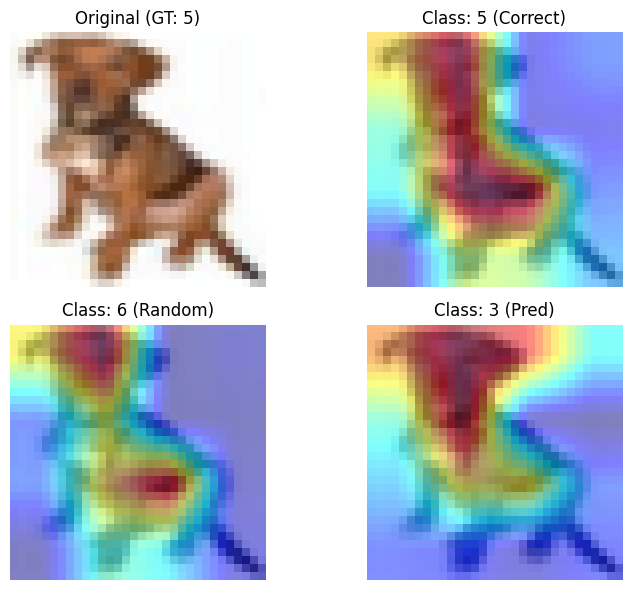

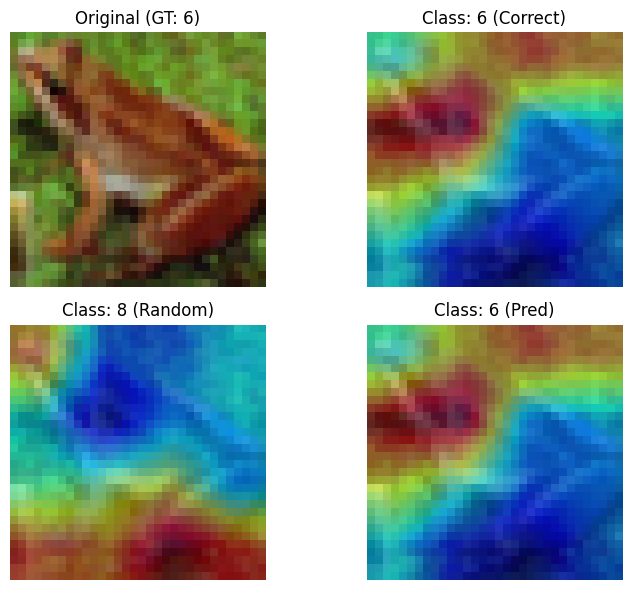

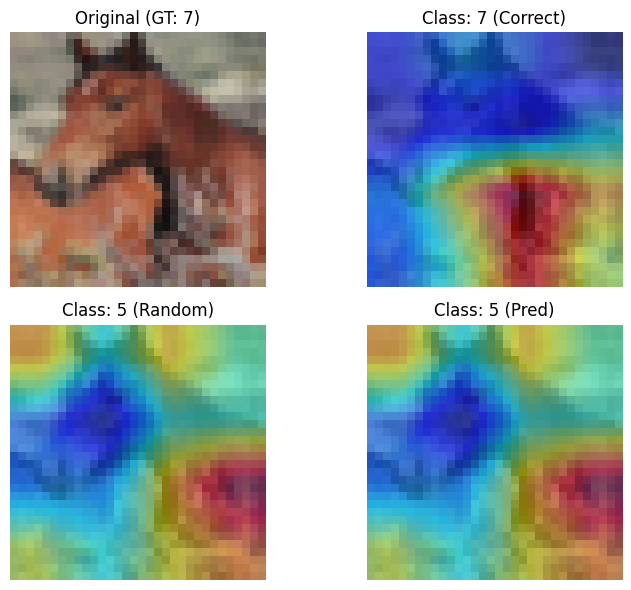

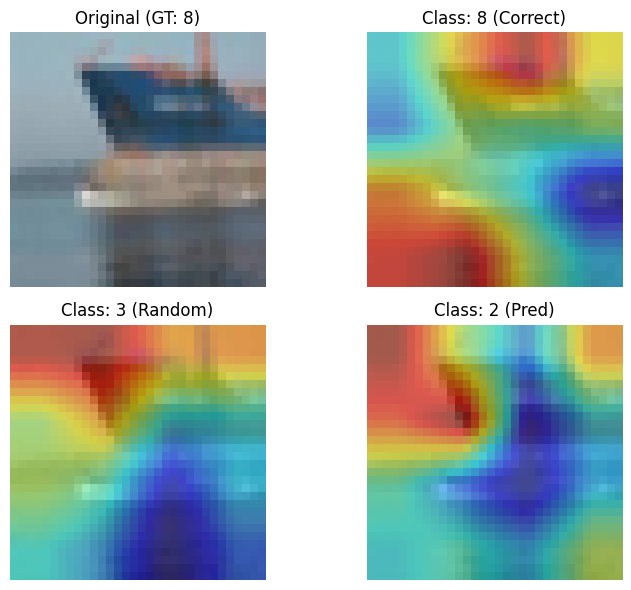

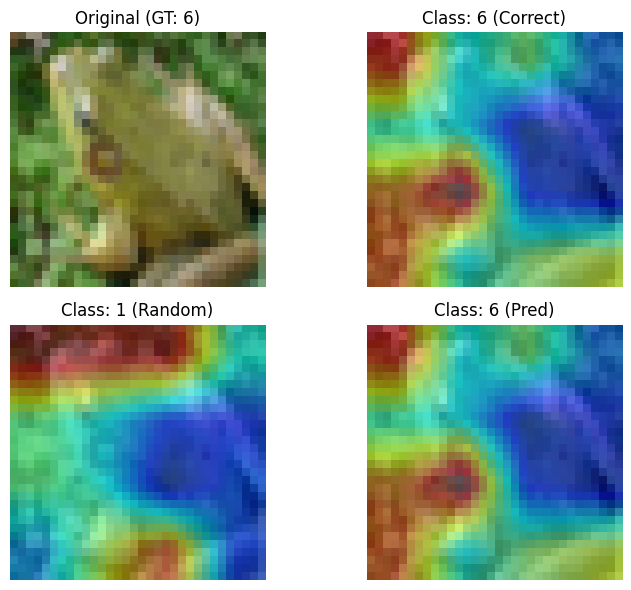

In [52]:
visualize_explanations(
    images[indices],
    heatmaps[indices],
    labels[indices],
    class_ids_list=class_ids[indices],
    mean=cfg.dataset.norm_mean,
    std=cfg.dataset.norm_std,
    show=True,
    save=False,
    show_original=True,
    index_names=["Correct", "Random", "Pred"],
)